# Overview
### **<center>Кейс 4. Классификация с использованием набора данных об академических успехах.</center>**

*Состав:*
- Музафаров Карим
- Цуркан Владислав
- Зенченко Илья
- Лямцев Иван
- Скиф Даниель
- Богдан Бабийчук

## Краткий обзор набора данных:
Цель: Набор данных был создан в рамках проекта, направленного на сокращение отсева и неуспеваемости в высших учебных заведениях.  

<br>
Признаки в наборе:  

- Perosonal Information: Marital status, gender, age at enrollment, nationality, international status, displaces status
- Family Background: Mother's and father's qualification and occupation
- Application and Admission: Application mode, application order, course, admission grade
- Academic Background: Previous qualification, previous qualification grade
- Academic Performance: Curricular units in the 1st and 2nd semesters(credited, enrolled, evaluations, approved, grades, without evaluations)
- Attendance and Financial Status: Daytime/evening attendance, educational special needs, debtor status, tuition fees up to data, scholarship holder
- Economic Indicators: Unemployment rate, inflation rate, GDP  
<br>
<br>  

- Личная информация: Семейное положение, пол, возраст при поступлении, гражданство, статус иностранного студента, статус перемещенного лица
- Семейное происхождение: Образование и профессия матери и отца
- Подача заявления и зачисление: Способ подачи заявления, очередность заявления, курс, вступительный балл
- Академическая история: Предыдущее образование, оценка предыдущего образования
- Академическая успеваемость: Учебные единицы в 1-м и 2-м семестрах (зачтенные, зачисленные, оценки, утвержденные, баллы, без оценок)
- Посещаемость и финансовое положение: Посещение дневных/вечерних занятий, особые образовательные потребности, статус должника, своевременная оплата обучения, стипендиат
- Экономические показатели: Уровень безработицы, уровень инфляции, ВВП   
<br>  

*Над набором данных была проведена предварительная обработка данных для устранения аномалий, необъяснимых выбросов и пропущенных значений. Набор не содержит дубликатов.*

# Import libraries

In [34]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

from category_encoders import TargetEncoder, OrdinalEncoder

import phik
from phik.report import plot_correlation_matrix

import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

# Import data

In [3]:
train = pd.read_csv("../data/train.csv", index_col="id")
test = pd.read_csv("../data/test.csv", index_col="id")

# EDA

## Общая информация по датасету

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

Набор данных содержит 3 класса: Graduate, Dropout, Enrolled. В рамках нашей задачи поставлена цель сократить количество не закончивших(Dropout) обучение в высшем учебном заведении. В таком случае есть смысл избавиться от необходимости классификации обучающихся в данный момент(Enrolled). Обнаруживать студентов в группе риска планируется по данным на момент поступления (из набора данных также будут удалены данные по успеваемости за 1-2 семестр и другие признаки влияющие на утечку данных).

In [5]:
target = "Target"
enrolled_class_name = "Enrolled"

train = train[train[target] != enrolled_class_name]


# Список признаков для удаления
delete_features = [
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)', 
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Debtor'
]

train = train.drop(columns=delete_features, errors='ignore')
test = test.drop(columns=delete_features, errors='ignore')

Информация после удаления

In [6]:
train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Educational special needs,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,1,0,1,18,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,1,0,0,18,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,1,1,0,18,0,16.2,0.3,-0.92,Dropout
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,1,0,0,18,0,7.6,2.6,0.32,Graduate
5,1,39,1,171,1,19,133.1,1,19,19,...,0,1,1,0,24,0,13.9,-0.3,0.79,Dropout


## Выделим признаки по типу данных

In [7]:
features = test.columns.to_list()

categorical_features = train.select_dtypes(include=int).columns.to_list()
continuous_features = train.select_dtypes(include=float).columns.to_list()

binary_features = [col for col in categorical_features 
                   if train[col].nunique() == 2 and col != target]

discrete_features = [col for col in categorical_features 
                     if col.startswith("Curricular")] + ["Age at enrollment"]

numeric_features = continuous_features + discrete_features

multi_category_features = [col for col in categorical_features 
                          if col not in binary_features and col not in discrete_features and col != target]

categorical_features = binary_features + multi_category_features


In [8]:
print(f"Числовые признаки: {numeric_features}")
print(f"Бинарные признаки: {binary_features}")
print(f"Категориальные признаки: {multi_category_features}")

Числовые признаки: ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP', 'Age at enrollment']
Бинарные признаки: ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
Категориальные признаки: ['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]


## Проверка на пропуски и дубликаты

In [9]:
train.isna().sum()

Marital status                    0
Application mode                  0
Application order                 0
Course                            0
Daytime/evening attendance        0
Previous qualification            0
Previous qualification (grade)    0
Nacionality                       0
Mother's qualification            0
Father's qualification            0
Mother's occupation               0
Father's occupation               0
Admission grade                   0
Displaced                         0
Educational special needs         0
Tuition fees up to date           0
Gender                            0
Scholarship holder                0
Age at enrollment                 0
International                     0
Unemployment rate                 0
Inflation rate                    0
GDP                               0
Target                            0
dtype: int64

In [10]:
train.duplicated().sum()

np.int64(78)

После удаления части признаков у нас появились дубликаты. Так как в изначальном наборе данных дубликатов не было, мы можем быть уверены, что это разные объекты и оставить их без изменений.

In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,61578.0,1.118516,0.451832,1.00,1.0,1.00,1.00,6.00
Application mode,61578.0,16.146140,16.673750,1.00,1.0,17.00,39.00,53.00
Application order,61578.0,1.675680,1.258984,0.00,1.0,1.00,2.00,6.00
Course,61578.0,8954.825197,1925.809939,33.00,9119.0,9254.00,9670.00,9991.00
Daytime/evening attendance,61578.0,0.911202,0.284454,0.00,1.0,1.00,1.00,1.00
Previous qualification,61578.0,3.639076,8.400165,1.00,1.0,1.00,1.00,43.00
Previous qualification (grade),61578.0,132.890601,11.117593,95.00,127.0,133.10,140.00,190.00
Nacionality,61578.0,1.225860,3.334185,1.00,1.0,1.00,1.00,109.00
Mother's qualification,61578.0,20.118321,15.423290,1.00,1.0,19.00,37.00,44.00
Father's qualification,61578.0,23.492579,14.961971,1.00,3.0,19.00,37.00,44.00


- Пропусков нет
- Наблюдается сильный дисбаланс в категориальных признаках

### Количество студентов в каждой категории целевого признака

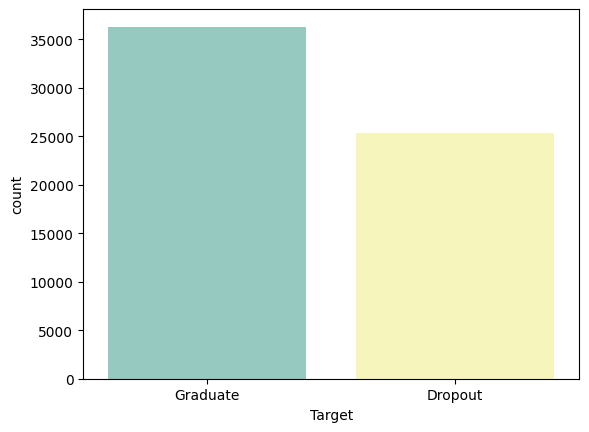

In [12]:
sns.countplot(data=train, x=target, hue=target, palette="Set3")
plt.show()

## Распределение признаков



### Распределение категориальных признаков

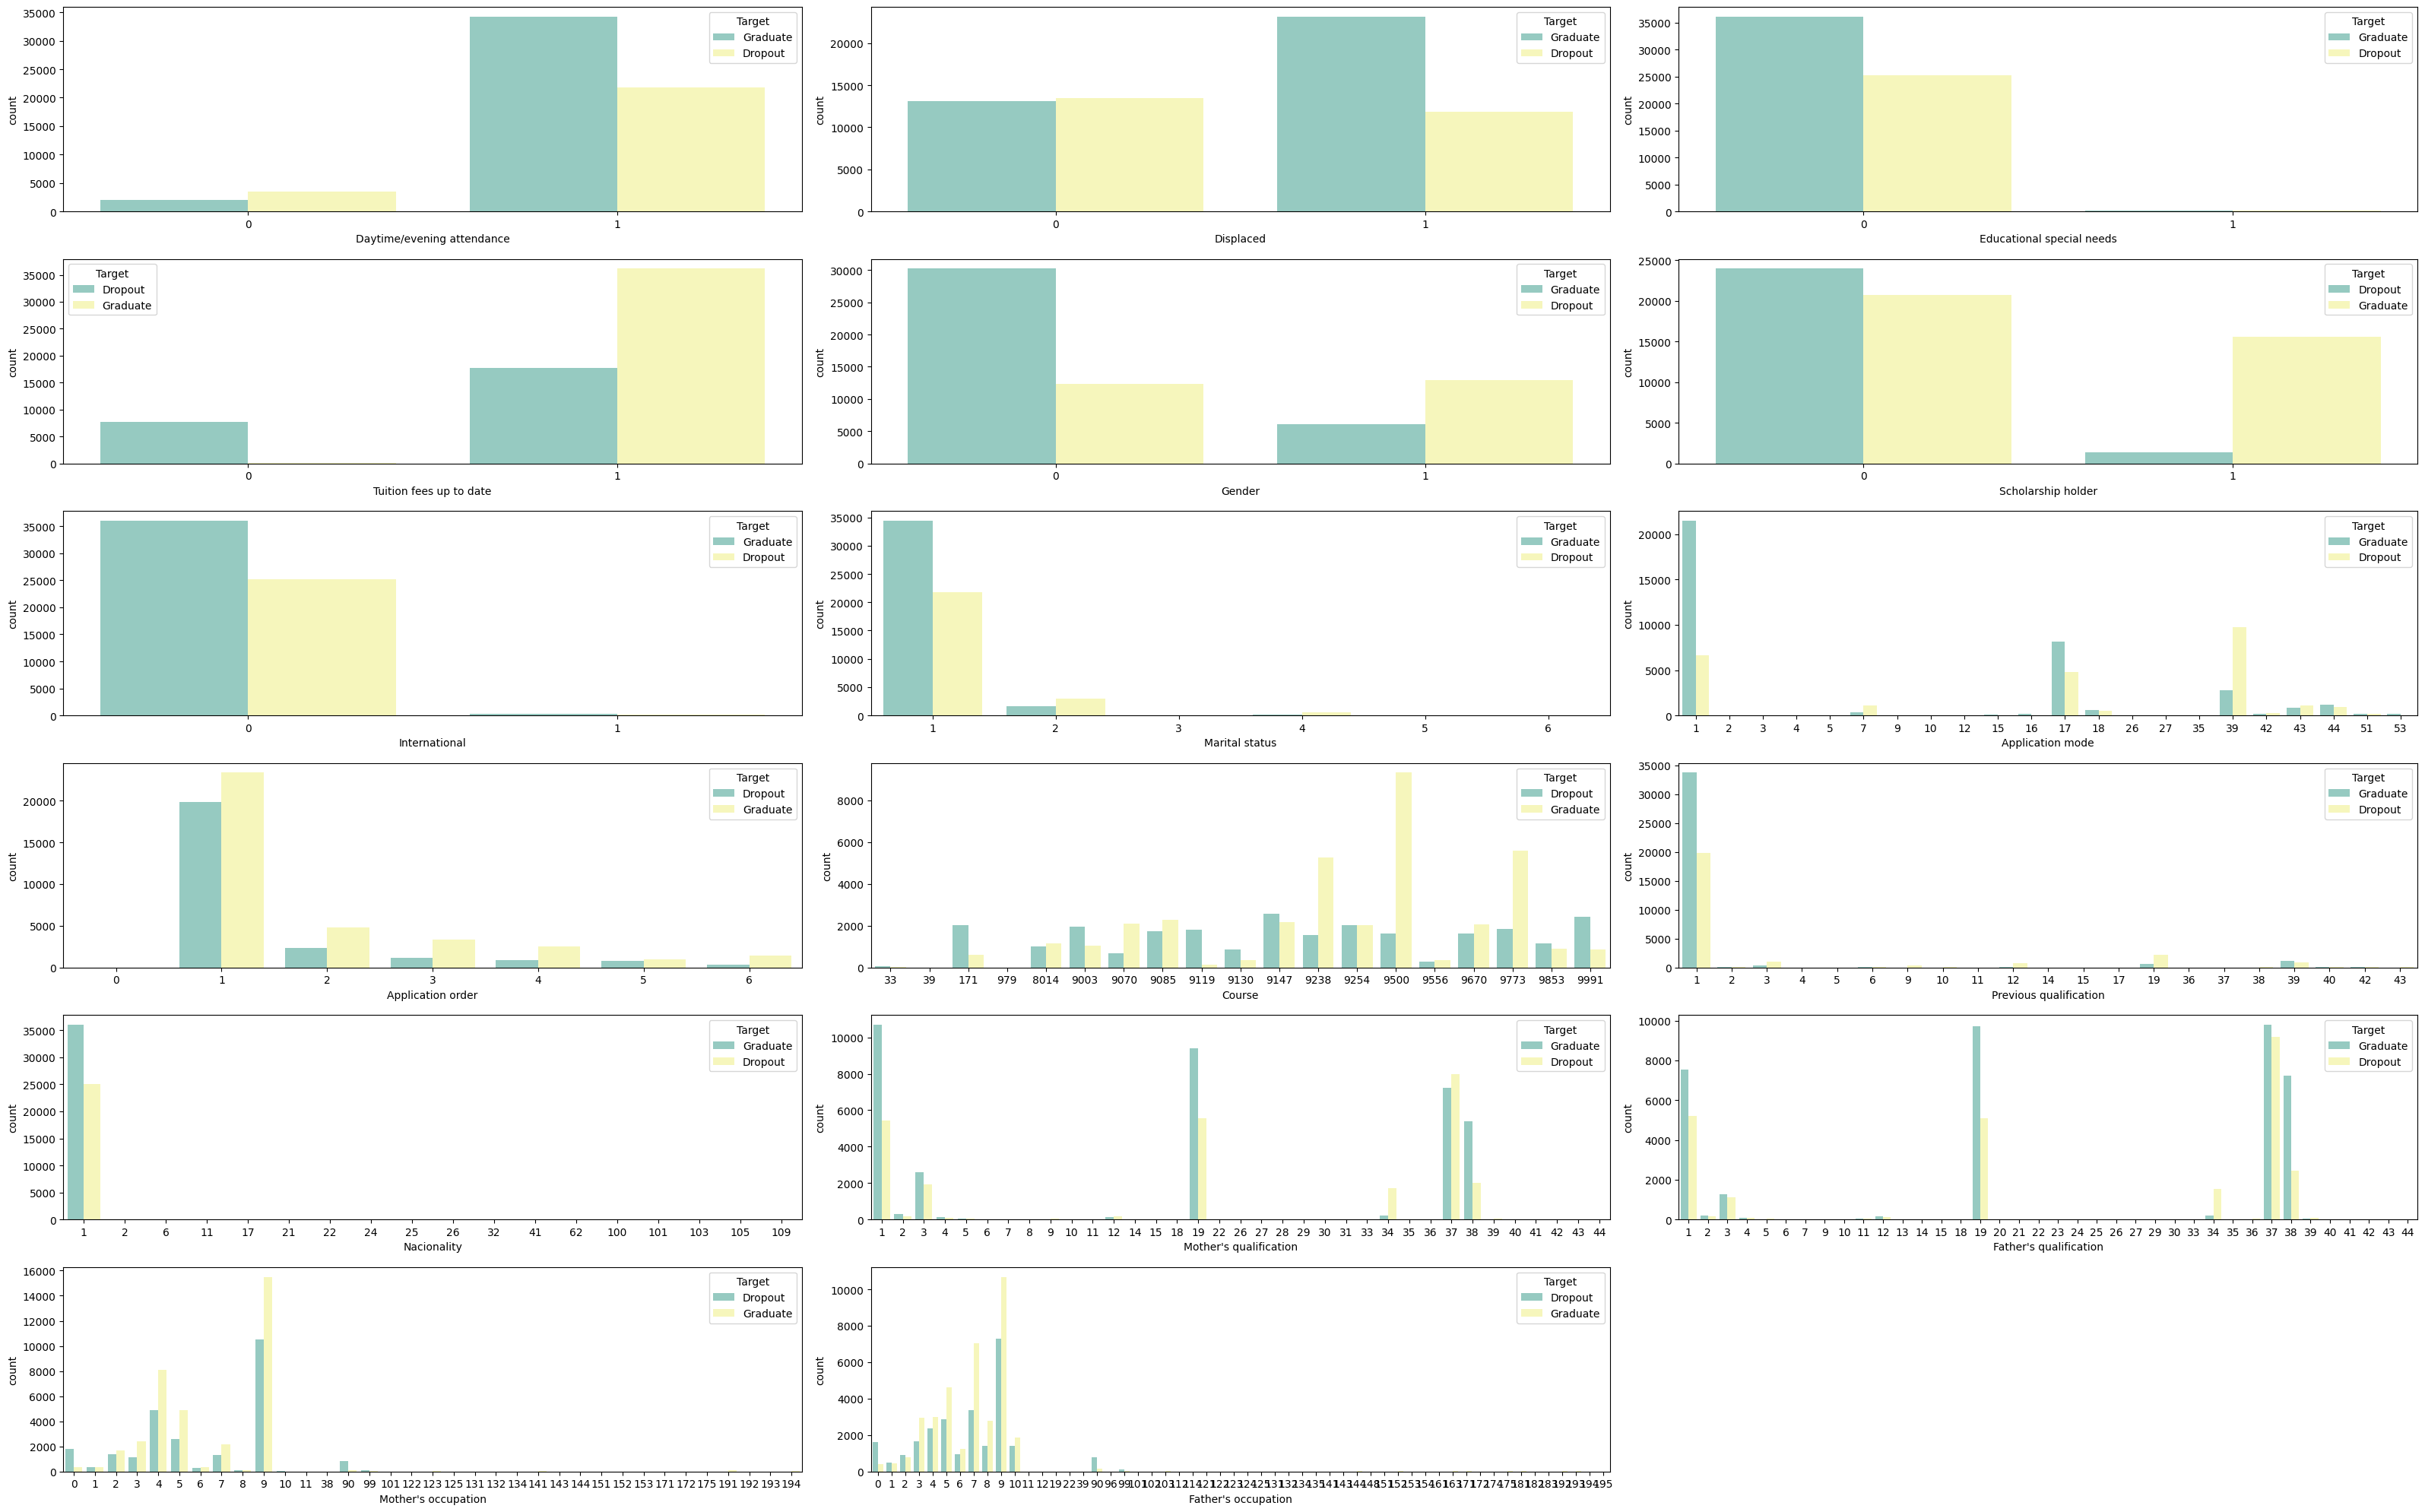

In [13]:
plt.figure(figsize=(32, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(6, 3, i+1)
    sns.countplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

🔵 1. Daytime/evening attendance (форма обучения)

1 (дневное обучение) → здесь много и Graduates, и Dropouts.
Но выпускников заметно больше.

0 (вечернее/другой формат) → здесь доля Dropout выше.

➡ Вывод:
Студенты вечерней формы чаще бросают учёбу.

🔵 2. Displaced (переселенец)

Среди displaced = 0 распределение одинаковое, по отношению к DropOut  
А вот те кто переезжал, чаще заканчивают, чем те кто не переезжал.

➡ Признак слабой силы

🔵 3. Educational special needs  

Почти все студенты → 0  

➡ Признак практически бесполезный для модели.

🔵 4. Tuition fees up to date (оплачено ли обучение)  

Те, кто не оплачивает вовремя, чаще Dropout  
Те, кто оплачивает, чаще Graduates  
➡ Финансовая дисциплина — сильный предиктор отчисления.  

🔵 5. Gender  

Кодировка примерно: 0 = женщины, 1 = мужчины  

Женщин больше среди выпускников  

Мужчины заметно чаще в группе Dropout  

➡ Мужчины чаще бросают учёбу.  

🔵 6. Scholarship holder (стипендия)  

Среди тех, кто не получает стипендию, много Dropout  

Среди тех, кто получает стипендию, доля выпускников выше  

➡ Стипендия = индикатор академической мотивации и успеха.  
Очень важный признак.

🔵 7. International (иностранный студент)  

Иностранцев очень мало  

Распределение случайное  

➡ Признак слабый из-за низкой выборки.  

🔵 8. Marital status (семейное положение)  

Значение 1 доминирует (неженат/незамужем)  

Другие статусы очень редки  

Различия между Graduate и Dropout почти нет  

➡ Признак низкой значимости.  

🔵 9. Application order (очередность выбора специальности)  

При выборе 1 → больше выпускников  

При выборе 2-6 → больше Dropout  

➡ Если программа — не первый выбор, растёт шанс отчисления.  

🔵 10. Course (учебная программа, код)  

Некоторые курсы (например, 9500–9600) → больше выпустившихся  

Другие курсы → дисбаланс в сторону Dropout  

➡ У разных программ радикально разные уровни отчисления.  
Код курса MUST be treated as a categorical label, not numeric.  

🔵 11. Previous qualification (тип предыд. образования)  

➡ Тип образования сильно влияет на риск отчисления.  
Студенты с низкой/нестабильной образовательной базой чаще уходят.  


🔵 12. Mother's qualification  

Низкое образование матери → больше Dropout  

Более высокое образование → больше Graduates  

➡ Признак отражает socioeconomic background.  
Хороший предиктор.  

🔵 13. Father's qualification  

Такая же закономерность:  

низкие коды → много Dropout  

высокие коды → больше Graduates  

➡ Оба признака (мать/отец) коррелируют с академическим успехом детей.  

🔵 14. Mother's occupation  

Большинство студентов имеют родителей в низких категориях профессий  

Но при увеличении значения заметно растёт доля Dropout  

➡ Признак важен, но нелинейный.  

🔵 15. Father's occupation  

Поведение похожее на mother's occupation.  

➡ Семейный социально-экономический статус сильно влияет на успех.  

### Распределение числовых признаков

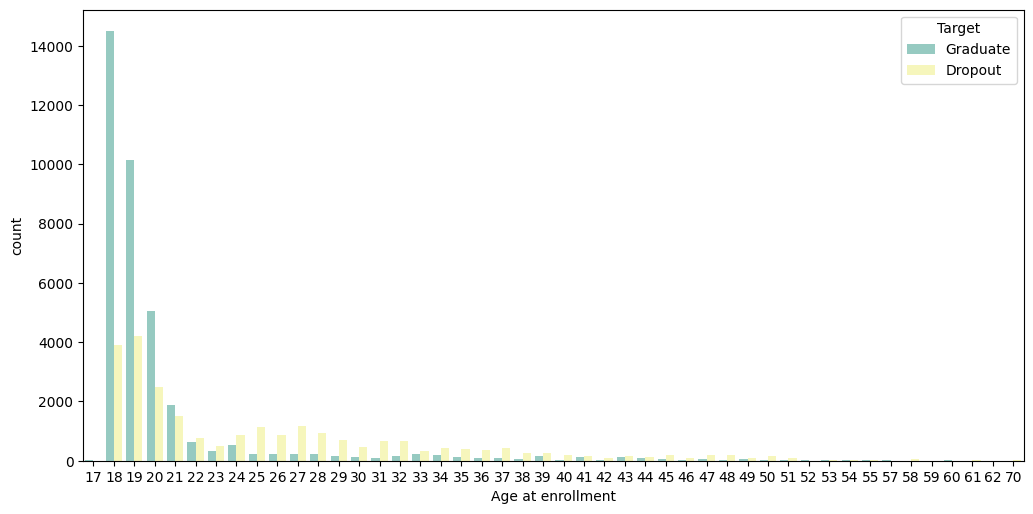

In [14]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

- Возраст — один из сильнейших предикторов отчисления.

- 17–19 лет → большинство успешно выпускаются.

- 20–25 лет → риск отчисления резко растёт.

- 25–35 лет → Dropout встречается чаще, чем Graduate.

- 35+ лет → почти все студенты — Dropout.

Правосторонняя ассиметрия по возрсту

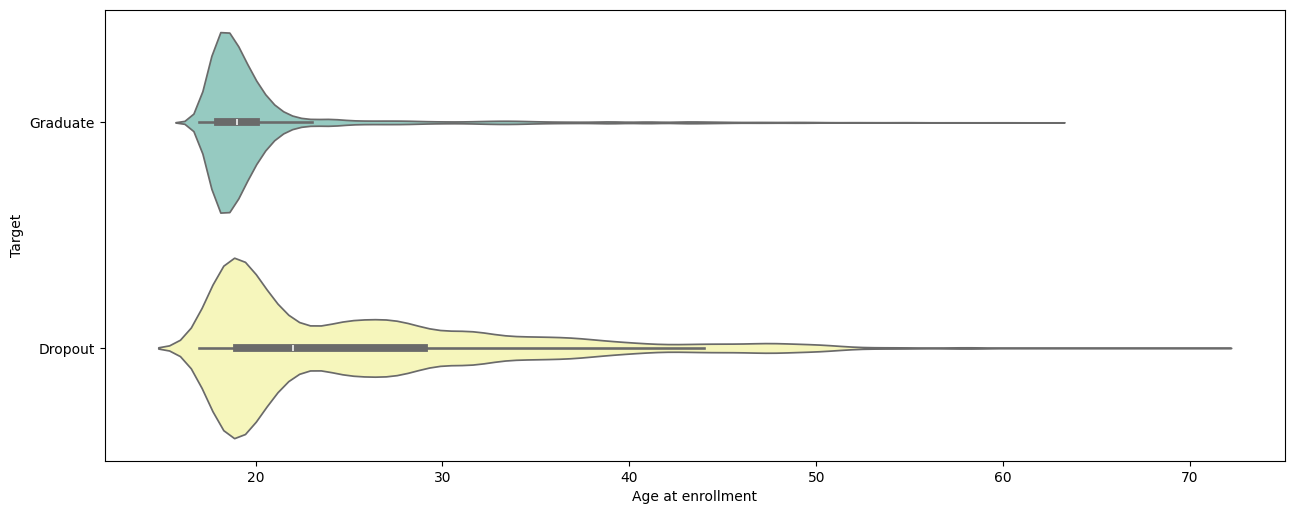

In [15]:
plt.figure(figsize=(25, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(3, 2, i+1)
    sns.violinplot(data=train, x=col, y=target, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

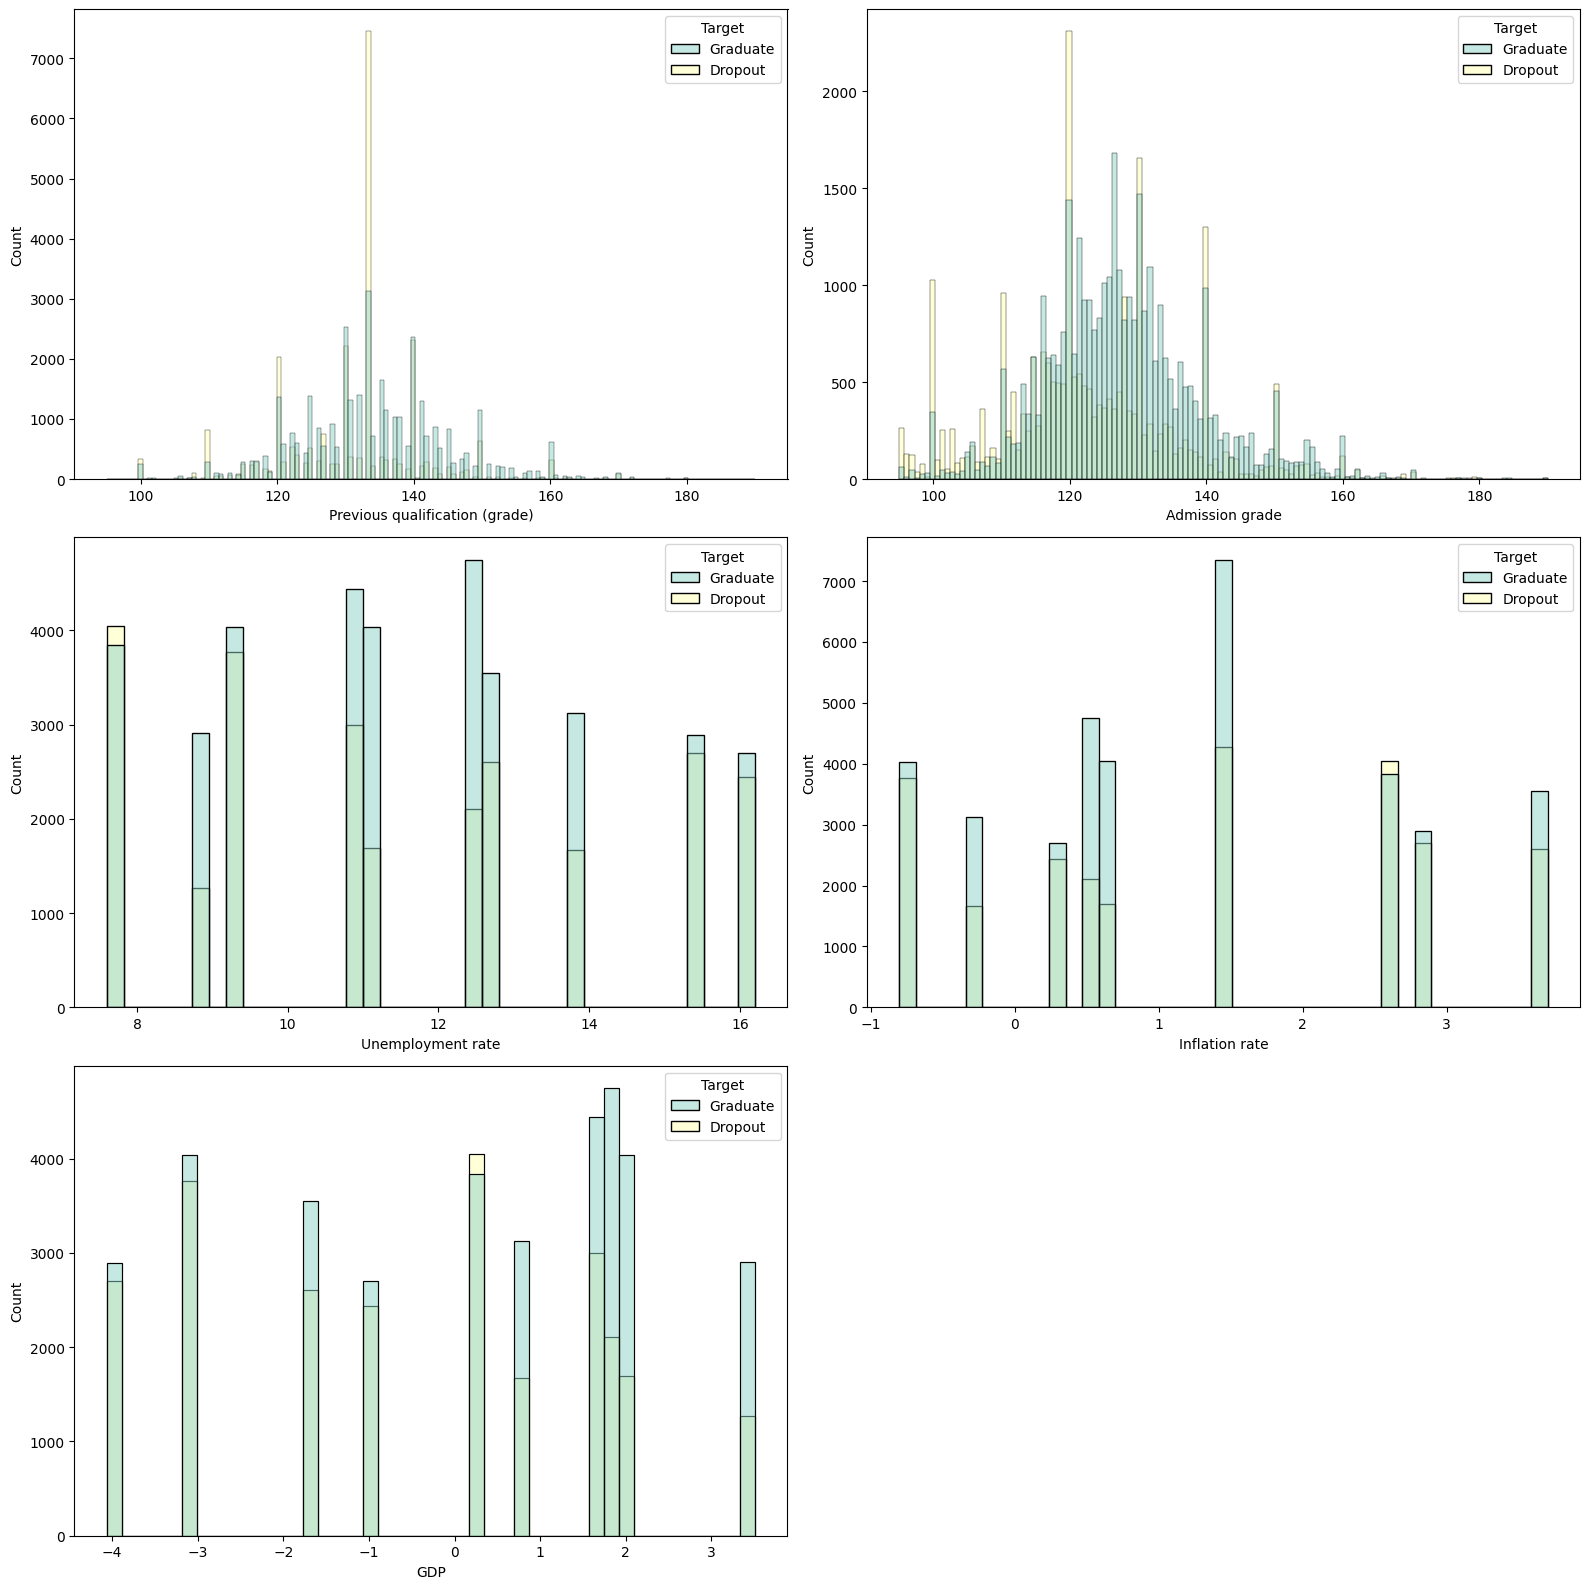

In [16]:
plt.figure(figsize=(16, 16))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

1. Previous qualification (grade) (оценка предыдущего образования)  
У выпускников оценки обычно выше.
У отчисленных много студентов с низкими оценками.
Распределение Dropout смещено влево → к худшим результатам.
- Чем выше предыдущая оценка, тем ниже риск отчисления.

2. Admission grade (вступительная оценка)  
У Graduate заметно больше студентов с баллами 120–150.
У Dropout больше студентов ниже 110–120.
- Высокий вступительный балл — сильный фактор успешного выпуска.

3. Unemployment rate  
Распределения групп почти совпадают.
Небольшое смещение: при более высоком уровне безработицы slightly ↑ Dropout.
- Признак слабой силы. Социально-экономическая среда почти не влияет.

4. Inflation rate  
Почти одинаковые распределения для обеих групп.
Нет заметного разделения между Graduate и Dropout.
- Инфляция не влияет на вероятность отчисления.

5. GDP(ВВП)  
Почти одинаковое распределение, признак бесполезный

## Корреляция

interval columns not set, guessing: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate', 'Inflation rate', 'GDP', 'Target']


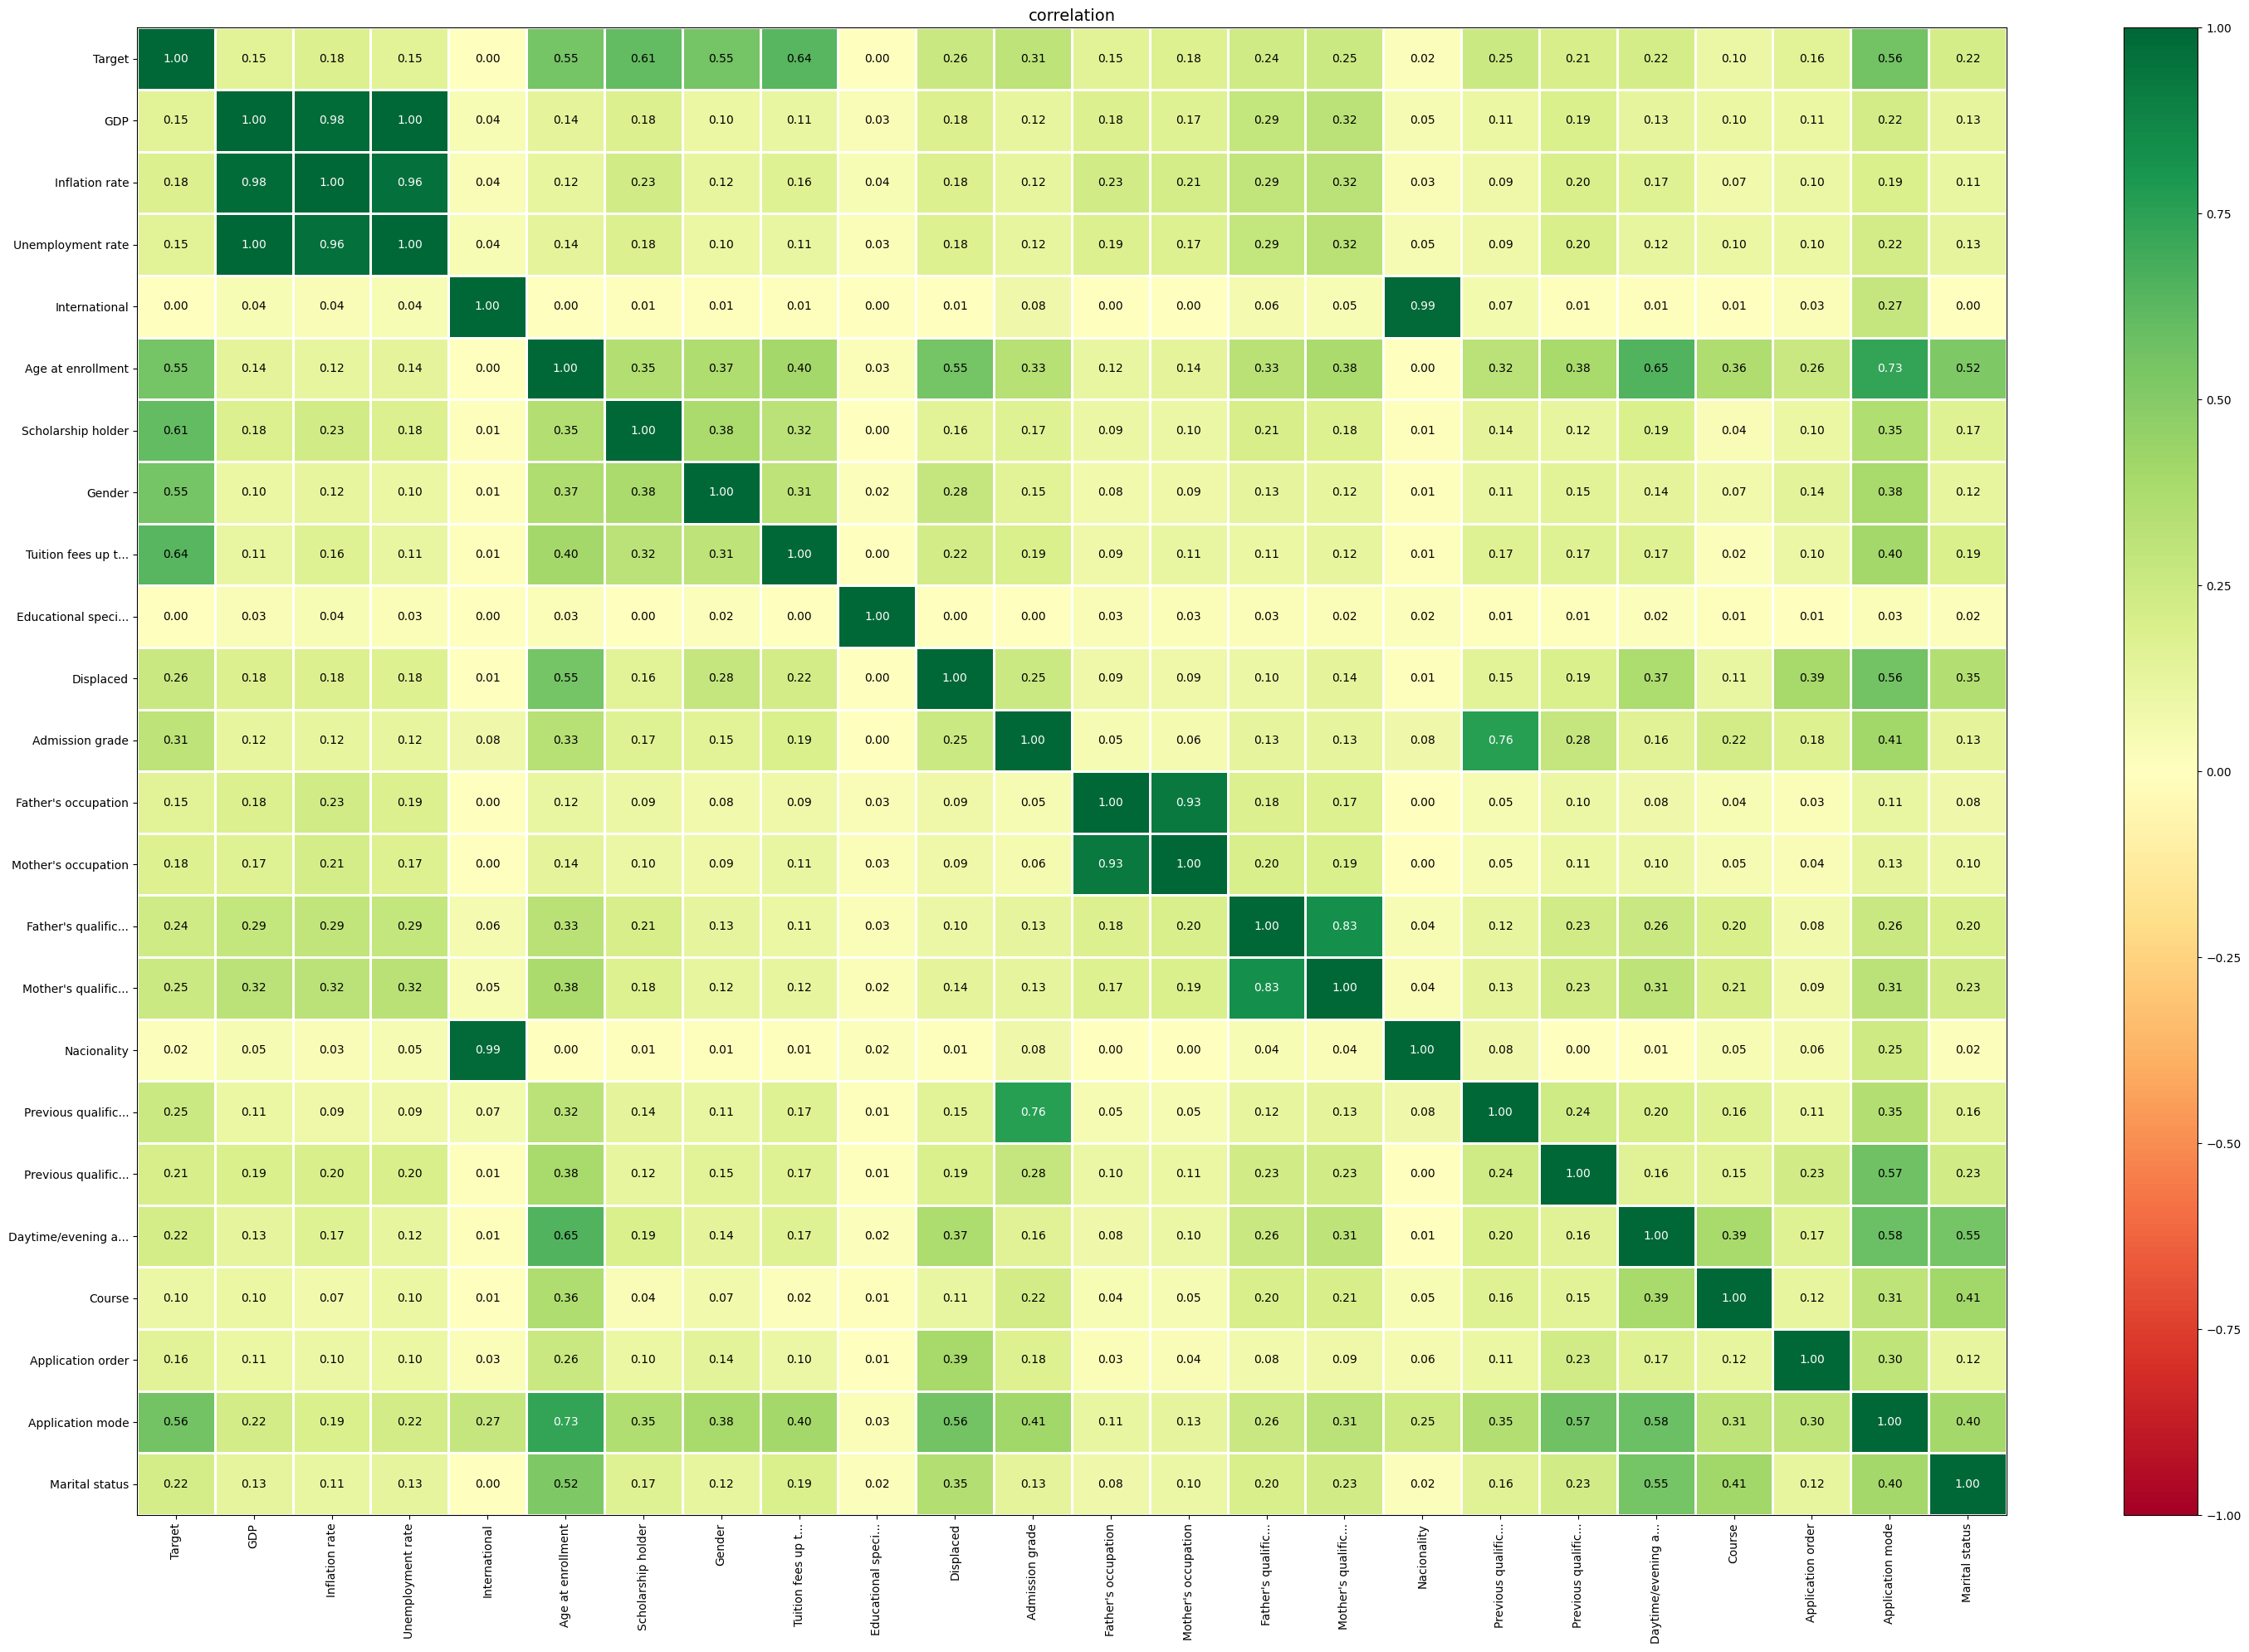

In [17]:
train["Target"] = (train["Target"] == 'Dropout').astype(int)


corr_matrix = train.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(30,20))

### Выводы:
- Наблюдается дисбаланс целевых классов
- Ряд признаков имеет сильную правостороннюю асимметрию и выбросы.
- Категориальные признаки зачастую несбалансированны.


Feature engineering
- Между nacionality(национальность) и international(является ли иностранным студентом) сильная корреляция. Можно дропнуть nacionality и оставить только признак international.
- Между Unemployment rate(Уровень безработицы), Inflation rate(Уровень инфляции), GDP(Валовой внутренний продукт) сильная корреляция. Можно оставить один признак из них(unemployment rate больше всего коррелирует с target)

# Baseline model

In [18]:
X = train.drop(target, axis=1).copy()
y = train[target].copy()

- Recall выбран как основная метрика, потому что в задаче прогнозирования отчисления студентов критически важно минимизировать число пропущенных случаев (ложно отрицательных), когда студент отчисляется, но модель этого не предсказала. Пропуск таких студентов означает упущенную возможность оказать им поддержку.
- Для числовых признаков выбран RobustScaler, так как анализ распределений показал наличие выбросов в данных.
- Для категориальных признаков применён TargetEncoder, так как он эффективно преобразует категории в числовые признаки, отражающие статистическую связь с целевой переменной. При использовании OHE у нас будет большое количество признаков.

In [19]:
numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 
    'Inflation rate', 'GDP'
]

discrete_features = [
    'Age at enrollment'
]

binary_features = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

categorical_features = [
    'Marital status', 'Application mode', 'Application order', 
    'Course', 'Previous qualification', 'Nacionality', 
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation"
]

def create_pipeline(C=1.0, penalty='l2', solver='lbfgs', 
                   class_weight=None, smoothing=10.0):
    
    preprocessor = ColumnTransformer([
        ('scaler', RobustScaler(), numerical_features + discrete_features),
        ('binary', 'passthrough', binary_features),
        ('cat', TargetEncoder(cols=categorical_features, smoothing=smoothing), 
         categorical_features)
    ], remainder='drop')
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    return pipeline

def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 10, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'smoothing': trial.suggest_float('smoothing', 1, 100, log=True),
    }
    
    if params['penalty'] == 'l1':
        params['solver'] = 'liblinear'
    else:
        params['solver'] = 'lbfgs'
    
    pipeline = create_pipeline(**params)
    
    cv_score = cross_val_score(
        pipeline, X, y,
        cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
        scoring='recall',
        n_jobs=-1
    ).mean()
    
    return cv_score

In [20]:
print("Оптимизация гиперпараметров...")
study = optuna.create_study(direction='maximize', study_name='logreg_opt')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Находим лучшие гиперпараметры модели логистической регрессии

print(f"\nЛучший recall: {study.best_value:.4f}")

[I 2025-12-05 13:35:53,005] A new study created in memory with name: logreg_opt


Оптимизация гиперпараметров...


Best trial: 0. Best value: 0.737192:   2%|▏         | 1/50 [00:03<02:54,  3.57s/it]

[I 2025-12-05 13:35:56,576] Trial 0 finished with value: 0.7371917389609297 and parameters: {'C': 7.776326127842334, 'penalty': 'l2', 'class_weight': None, 'smoothing': 7.351382525777765}. Best is trial 0 with value: 0.7371917389609297.


Best trial: 0. Best value: 0.737192:   4%|▍         | 2/50 [00:06<02:27,  3.08s/it]

[I 2025-12-05 13:35:59,313] Trial 1 finished with value: 0.6969483622367791 and parameters: {'C': 0.0023188147979109914, 'penalty': 'l2', 'class_weight': None, 'smoothing': 95.92307289247397}. Best is trial 0 with value: 0.7371917389609297.


Best trial: 0. Best value: 0.737192:   6%|▌         | 3/50 [00:08<02:03,  2.63s/it]

[I 2025-12-05 13:36:01,410] Trial 2 finished with value: 0.7254111232142204 and parameters: {'C': 0.017584966966471893, 'penalty': 'l2', 'class_weight': None, 'smoothing': 14.15829223172804}. Best is trial 0 with value: 0.7371917389609297.


Best trial: 0. Best value: 0.737192:   8%|▊         | 4/50 [00:10<01:49,  2.38s/it]

[I 2025-12-05 13:36:03,415] Trial 3 finished with value: 0.7213393050109783 and parameters: {'C': 0.011301153806925224, 'penalty': 'l2', 'class_weight': None, 'smoothing': 4.9260758434598175}. Best is trial 0 with value: 0.7371917389609297.


Best trial: 4. Best value: 0.737468:  10%|█         | 5/50 [00:12<01:48,  2.41s/it]

[I 2025-12-05 13:36:05,862] Trial 4 finished with value: 0.7374684625579178 and parameters: {'C': 1.8867605947931936, 'penalty': 'l2', 'class_weight': None, 'smoothing': 60.276017332731044}. Best is trial 4 with value: 0.7374684625579178.


Best trial: 4. Best value: 0.737468:  12%|█▏        | 6/50 [00:14<01:40,  2.29s/it]

[I 2025-12-05 13:36:07,915] Trial 5 finished with value: 0.6637018376709382 and parameters: {'C': 0.0011661945194814368, 'penalty': 'l1', 'class_weight': None, 'smoothing': 1.2623948417917226}. Best is trial 4 with value: 0.7374684625579178.


Best trial: 6. Best value: 0.787081:  14%|█▍        | 7/50 [00:16<01:34,  2.20s/it]

[I 2025-12-05 13:36:09,951] Trial 6 finished with value: 0.7870812519254297 and parameters: {'C': 0.003974859013307584, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 4.334179833960208}. Best is trial 6 with value: 0.7870812519254297.


Best trial: 7. Best value: 0.799297:  16%|█▌        | 8/50 [02:07<25:37, 36.60s/it]

[I 2025-12-05 13:38:00,197] Trial 7 finished with value: 0.799296739357312 and parameters: {'C': 1.0576757735339708, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 76.96904217338204}. Best is trial 7 with value: 0.799296739357312.


Best trial: 8. Best value: 0.799811:  18%|█▊        | 9/50 [02:09<17:38, 25.82s/it]

[I 2025-12-05 13:38:02,322] Trial 8 finished with value: 0.7998107343198112 and parameters: {'C': 0.12025739437001245, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 37.59324012588449}. Best is trial 8 with value: 0.7998107343198112.


Best trial: 8. Best value: 0.799811:  20%|██        | 10/50 [02:11<12:23, 18.58s/it]

[I 2025-12-05 13:38:04,677] Trial 9 finished with value: 0.7994153695697083 and parameters: {'C': 1.8567835621882847, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 93.98556120536686}. Best is trial 8 with value: 0.7998107343198112.


Best trial: 10. Best value: 0.79989:  22%|██▏       | 11/50 [02:31<12:20, 18.98s/it]

[I 2025-12-05 13:38:24,569] Trial 10 finished with value: 0.799889813834263 and parameters: {'C': 0.15741724890923822, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 25.48225365025263}. Best is trial 10 with value: 0.799889813834263.


Best trial: 10. Best value: 0.79989:  24%|██▍       | 12/50 [02:55<12:59, 20.51s/it]

[I 2025-12-05 13:38:48,572] Trial 11 finished with value: 0.7997316985682341 and parameters: {'C': 0.2218836716791314, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 24.432409532219488}. Best is trial 10 with value: 0.799889813834263.


Best trial: 12. Best value: 0.799929:  26%|██▌       | 13/50 [03:09<11:26, 18.56s/it]

[I 2025-12-05 13:39:02,655] Trial 12 finished with value: 0.7999293317100516 and parameters: {'C': 0.07874742436303656, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 26.239167453457156}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  28%|██▊       | 14/50 [03:17<09:11, 15.31s/it]

[I 2025-12-05 13:39:10,466] Trial 13 finished with value: 0.7997317095089528 and parameters: {'C': 0.041199754259860624, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 18.133419906165408}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  30%|███       | 15/50 [03:41<10:29, 17.98s/it]

[I 2025-12-05 13:39:34,631] Trial 14 finished with value: 0.7998107233790925 and parameters: {'C': 0.34198241188466105, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 32.78812985800919}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  32%|███▏      | 16/50 [03:49<08:29, 14.98s/it]

[I 2025-12-05 13:39:42,652] Trial 15 finished with value: 0.7995340544856979 and parameters: {'C': 0.04664913466902984, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 10.657986662400518}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  34%|███▍      | 17/50 [04:11<09:17, 16.91s/it]

[I 2025-12-05 13:40:04,037] Trial 16 finished with value: 0.7998502631363185 and parameters: {'C': 0.3304481936261229, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 39.279485517236274}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  36%|███▌      | 18/50 [04:19<07:39, 14.37s/it]

[I 2025-12-05 13:40:12,491] Trial 17 finished with value: 0.7998107343198113 and parameters: {'C': 0.059399263991864605, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 2.4857476010053516}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  38%|███▊      | 19/50 [04:24<05:58, 11.55s/it]

[I 2025-12-05 13:40:17,490] Trial 18 finished with value: 0.7964110810486906 and parameters: {'C': 0.01171620967971444, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 15.150358812847813}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  40%|████      | 20/50 [05:53<17:23, 34.77s/it]

[I 2025-12-05 13:41:46,380] Trial 19 finished with value: 0.799375807931045 and parameters: {'C': 0.9053265254302991, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 48.80219083226682}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  42%|████▏     | 21/50 [06:15<14:55, 30.88s/it]

[I 2025-12-05 13:42:08,199] Trial 20 finished with value: 0.7998107343198112 and parameters: {'C': 0.14683228390563507, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 20.99800791988987}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  44%|████▍     | 22/50 [06:48<14:46, 31.67s/it]

[I 2025-12-05 13:42:41,697] Trial 21 finished with value: 0.7994548983862154 and parameters: {'C': 0.5113241116121381, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 31.349790058229186}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  46%|████▌     | 23/50 [07:05<12:18, 27.34s/it]

[I 2025-12-05 13:42:58,949] Trial 22 finished with value: 0.7996130574151191 and parameters: {'C': 0.10572202250211217, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 48.314173028863806}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  48%|████▊     | 24/50 [07:29<11:22, 26.25s/it]

[I 2025-12-05 13:43:22,649] Trial 23 finished with value: 0.7998107452605298 and parameters: {'C': 0.295390935516488, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 24.870178403337132}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  50%|█████     | 25/50 [07:37<08:37, 20.70s/it]

[I 2025-12-05 13:43:30,390] Trial 24 finished with value: 0.7995341201300098 and parameters: {'C': 0.028625494505011194, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 9.624462616980058}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  52%|█████▏    | 26/50 [08:19<10:50, 27.11s/it]

[I 2025-12-05 13:44:12,450] Trial 25 finished with value: 0.7995734957764559 and parameters: {'C': 0.5229099527297099, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 43.65730865855113}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 12. Best value: 0.799929:  54%|█████▍    | 27/50 [10:45<24:01, 62.67s/it]

[I 2025-12-05 13:46:38,091] Trial 26 finished with value: 0.7994548436826222 and parameters: {'C': 3.7814996697602874, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 63.573589997047826}. Best is trial 12 with value: 0.7999293317100516.


Best trial: 27. Best value: 0.800206:  56%|█████▌    | 28/50 [10:57<17:26, 47.57s/it]

[I 2025-12-05 13:46:50,430] Trial 27 finished with value: 0.8002060990699141 and parameters: {'C': 0.07101705955840407, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 27.43528143427952}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  58%|█████▊    | 29/50 [11:11<13:06, 37.45s/it]

[I 2025-12-05 13:47:04,287] Trial 28 finished with value: 0.7995735833022052 and parameters: {'C': 0.08739044507969576, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 13.653088763408924}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  60%|██████    | 30/50 [11:18<09:30, 28.51s/it]

[I 2025-12-05 13:47:11,911] Trial 29 finished with value: 0.7292458341627309 and parameters: {'C': 0.019028011804769755, 'penalty': 'l1', 'class_weight': None, 'smoothing': 7.006904878325921}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  62%|██████▏   | 31/50 [11:21<06:35, 20.84s/it]

[I 2025-12-05 13:47:14,867] Trial 30 finished with value: 0.7900463726736557 and parameters: {'C': 0.004350129357104277, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 24.969580854768317}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  64%|██████▍   | 32/50 [11:41<06:08, 20.48s/it]

[I 2025-12-05 13:47:34,492] Trial 31 finished with value: 0.7997712164440226 and parameters: {'C': 0.17850092735225537, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 30.32259501011515}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  66%|██████▌   | 33/50 [11:55<05:15, 18.56s/it]

[I 2025-12-05 13:47:48,584] Trial 32 finished with value: 0.8000479509817292 and parameters: {'C': 0.07643919894958125, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 18.669950946184066}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  68%|██████▊   | 34/50 [12:08<04:28, 16.76s/it]

[I 2025-12-05 13:48:01,133] Trial 33 finished with value: 0.8000874907389551 and parameters: {'C': 0.06709778247540267, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 18.03641945384092}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  70%|███████   | 35/50 [12:20<03:51, 15.46s/it]

[I 2025-12-05 13:48:13,579] Trial 34 finished with value: 0.7349383447834883 and parameters: {'C': 0.06288810659746794, 'penalty': 'l1', 'class_weight': None, 'smoothing': 16.65747020764716}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  72%|███████▏  | 36/50 [12:22<02:40, 11.48s/it]

[I 2025-12-05 13:48:15,751] Trial 35 finished with value: 0.7285736254677347 and parameters: {'C': 0.029256363627018958, 'penalty': 'l2', 'class_weight': None, 'smoothing': 11.209643654576217}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  74%|███████▍  | 37/50 [12:28<02:06,  9.70s/it]

[I 2025-12-05 13:48:21,317] Trial 36 finished with value: 0.796371563172902 and parameters: {'C': 0.011948903152756344, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 7.471955856973092}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  76%|███████▌  | 38/50 [12:30<01:29,  7.43s/it]

[I 2025-12-05 13:48:23,454] Trial 37 finished with value: 0.7149352428709347 and parameters: {'C': 0.006896824592063584, 'penalty': 'l2', 'class_weight': None, 'smoothing': 18.319467955122548}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  78%|███████▊  | 39/50 [12:39<01:27,  7.96s/it]

[I 2025-12-05 13:48:32,656] Trial 38 finished with value: 0.79953412013001 and parameters: {'C': 0.028117737207997484, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 7.421158002825276}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  80%|████████  | 40/50 [12:52<01:33,  9.33s/it]

[I 2025-12-05 13:48:45,189] Trial 39 finished with value: 0.7999293645322075 and parameters: {'C': 0.07810818836617171, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 13.742973196245446}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  82%|████████▏ | 41/50 [12:54<01:04,  7.17s/it]

[I 2025-12-05 13:48:47,312] Trial 40 finished with value: 0.7258855127751819 and parameters: {'C': 0.01829271926941132, 'penalty': 'l2', 'class_weight': None, 'smoothing': 4.700477897306195}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  84%|████████▍ | 42/50 [13:09<01:16,  9.51s/it]

[I 2025-12-05 13:49:02,292] Trial 41 finished with value: 0.7997317095089528 and parameters: {'C': 0.08081033737673349, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 14.102309590842964}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  86%|████████▌ | 43/50 [13:18<01:05,  9.38s/it]

[I 2025-12-05 13:49:11,370] Trial 42 finished with value: 0.7998502850177559 and parameters: {'C': 0.053422639438112804, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 20.258665487783272}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  88%|████████▊ | 44/50 [13:34<01:07, 11.32s/it]

[I 2025-12-05 13:49:27,220] Trial 43 finished with value: 0.7996130683558379 and parameters: {'C': 0.09906108360019328, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 12.600108949025644}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  90%|█████████ | 45/50 [13:48<01:01, 12.22s/it]

[I 2025-12-05 13:49:41,529] Trial 44 finished with value: 0.8002060881291956 and parameters: {'C': 0.07150385473050111, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 20.704910695948133}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  92%|█████████▏| 46/50 [13:56<00:44, 11.03s/it]

[I 2025-12-05 13:49:49,782] Trial 45 finished with value: 0.7997712492661787 and parameters: {'C': 0.03619634177107965, 'penalty': 'l1', 'class_weight': 'balanced', 'smoothing': 9.042609189986472}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 27. Best value: 0.800206:  94%|█████████▍| 47/50 [13:59<00:25,  8.44s/it]

[I 2025-12-05 13:49:52,178] Trial 46 finished with value: 0.8000479509817292 and parameters: {'C': 0.20268288328530507, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 20.333497643946778}. Best is trial 27 with value: 0.8002060990699141.


Best trial: 47. Best value: 0.800246:  96%|█████████▌| 48/50 [14:01<00:13,  6.59s/it]

[I 2025-12-05 13:49:54,467] Trial 47 finished with value: 0.8002455731828281 and parameters: {'C': 0.22746609210797306, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 21.002258400324838}. Best is trial 47 with value: 0.8002455731828281.


Best trial: 47. Best value: 0.800246:  98%|█████████▊| 49/50 [14:03<00:05,  5.15s/it]

[I 2025-12-05 13:49:56,245] Trial 48 finished with value: 0.7698845318741098 and parameters: {'C': 0.0012844066171028925, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 32.78397715073476}. Best is trial 47 with value: 0.8002455731828281.


Best trial: 47. Best value: 0.800246: 100%|██████████| 50/50 [14:05<00:00, 16.91s/it]

[I 2025-12-05 13:49:58,711] Trial 49 finished with value: 0.7999292988878958 and parameters: {'C': 0.5419025411507357, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 58.111446853871435}. Best is trial 47 with value: 0.8002455731828281.

Лучший recall: 0.8002


In [21]:
best_params = study.best_params.copy()
best_params['solver'] = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
final_pipeline = create_pipeline(**best_params)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(final_pipeline, X, y, cv=cv, n_jobs=-1)

report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     36282
           1       0.78      0.80      0.79     25296

    accuracy                           0.82     61578
   macro avg       0.82      0.82      0.82     61578
weighted avg       0.82      0.82      0.82     61578



- достаточно сбалансированная модель с хорошим recall для Dropout и Graduated
- В данной задаче нас больше волнует recall(полнота), т.к. критичнее ложноотрицательные предсказания

Text(50.722222222222214, 0.5, 'Истинные метки')

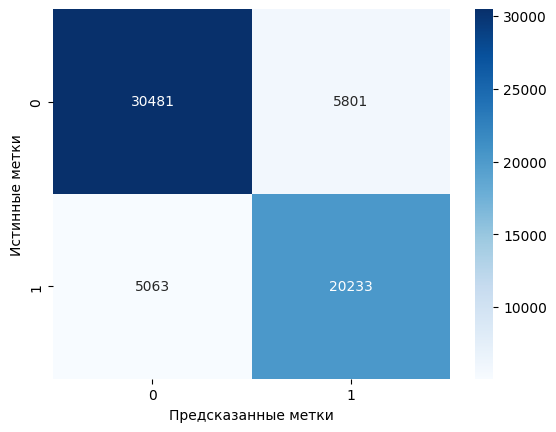

In [22]:
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')

- 30472 — правильно предсказанные выпускники

- 20231 — правильно предсказанные отчислившиеся

- 5065 — опасные ошибки (отчислился, но модель не заметила) очень мало

- 5810 — ложные тревоги (модель думала, что отчислится, но нет)

Итог: модель уверенно находит студентов, которые отчислятся, и почти не пропускает их.

In [23]:
print("Лучшие параметры:", study.best_params)

Лучшие параметры: {'C': 0.22746609210797306, 'penalty': 'l2', 'class_weight': 'balanced', 'smoothing': 21.002258400324838}


In [24]:
best_params = study.best_params.copy()
best_params['solver'] = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
final_model = create_pipeline(**best_params)
final_model.fit(X, y)

preprocessor = final_model.named_steps['preprocessor']


feature_names = []

feature_names.extend(numerical_features + discrete_features)

feature_names.extend(binary_features)

feature_names.extend(categorical_features)


coefs = final_model.named_steps['classifier'].coef_[0]


fi = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abs_coef=lambda d: d["coef"].abs())
      .sort_values("abs_coef", ascending=False)
)

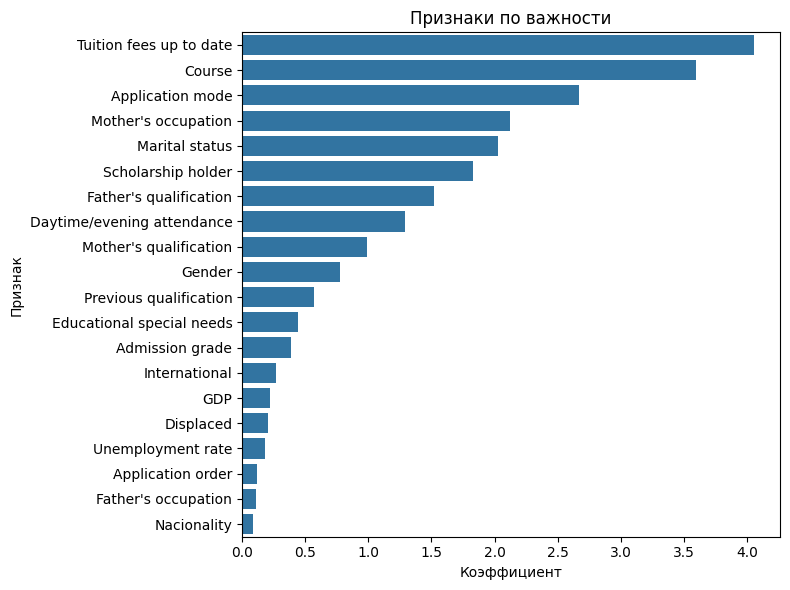

In [25]:
TOP_N = 20

plt.figure(figsize=(8, 6))
sns.barplot(data=fi.head(TOP_N), x="abs_coef", y="feature")
plt.xlabel("Коэффициент")
plt.ylabel("Признак")
plt.title(f"Признаки по важности")
plt.tight_layout()
plt.show()

# DT

In [26]:
num_features = ['Previous qualification (grade)', 'Admission grade', 
                'Unemployment rate', 'Inflation rate', 'GDP', 'Age at enrollment']

bin_features = ['Daytime/evening attendance', 'Displaced', 'Educational special needs',
                'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

cat_features = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 
                'Nacionality', "Mother's qualification", "Father's qualification",
                "Mother's occupation", "Father's occupation", 'Application order']


def create_dt_pipeline(params):
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', num_features),
        ('bin', 'passthrough', bin_features),
        ('cat', TargetEncoder(cols=categorical_features), 
         categorical_features)
    ], remainder='drop')
    
    dt_params = {k: v for k, v in params.items() if k not in ['preprocessor']}
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(**dt_params, random_state=42))
    ])
def objective(trial, X, y, cv_folds=5, scoring='recall'):

    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100, step=10),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.1)
    }
    
    pipeline = create_dt_pipeline(params)
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return scores.mean()

In [27]:
def optimize_decision_tree(X, y, n_trials=100, scoring='recall', cv_folds=5, timeout=None):
    study = optuna.create_study(
        direction='maximize',
        study_name='decision_tree_optimization',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    study.optimize(
        lambda trial: objective(trial, X, y, cv_folds, scoring),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True,
        n_jobs=1
    )
    

    print(f"Лучшее значение {scoring}: {study.best_value:.4f}")
    print("\nЛучшие параметры:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study

In [28]:
study = optimize_decision_tree(X, y, n_trials=100, scoring="recall")

[I 2025-12-05 13:50:03,358] A new study created in memory with name: decision_tree_optimization
Best trial: 0. Best value: 0:   1%|          | 1/100 [00:01<02:47,  1.70s/it]

[I 2025-12-05 13:50:05,056] Trial 0 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.08324426408004218, 'ccp_alpha': 0.021233911067827616}. Best is trial 0 with value: 0.0.


Best trial: 1. Best value: 0.802894:   2%|▏         | 2/100 [00:02<02:19,  1.42s/it]

[I 2025-12-05 13:50:06,288] Trial 1 finished with value: 0.8028936728422794 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.019967378215835975, 'ccp_alpha': 0.05142344384136116}. Best is trial 1 with value: 0.8028936728422794.


Best trial: 1. Best value: 0.802894:   3%|▎         | 3/100 [00:04<02:07,  1.31s/it]

[I 2025-12-05 13:50:07,470] Trial 2 finished with value: 0.8028936728422794 and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.012203823484477884, 'ccp_alpha': 0.04951769101112702}. Best is trial 1 with value: 0.8028936728422794.


Best trial: 3. Best value: 0.955487:   4%|▍         | 4/100 [00:05<02:00,  1.25s/it]

[I 2025-12-05 13:50:08,624] Trial 3 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.05978999788110852, 'ccp_alpha': 0.09218742350231168}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:   5%|▌         | 5/100 [00:06<01:56,  1.22s/it]

[I 2025-12-05 13:50:09,799] Trial 4 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': None, 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.007455064367977083, 'ccp_alpha': 0.09868869366005173}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:   6%|▌         | 6/100 [00:07<01:50,  1.17s/it]

[I 2025-12-05 13:50:10,879] Trial 5 finished with value: 0.2 and parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.03308980248526492, 'ccp_alpha': 0.006355835028602364}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:   7%|▋         | 7/100 [00:08<01:53,  1.22s/it]

[I 2025-12-05 13:50:12,167] Trial 6 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.05227328293819941, 'ccp_alpha': 0.042754101835854964}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:   8%|▊         | 8/100 [00:10<01:56,  1.27s/it]

[I 2025-12-05 13:50:13,548] Trial 7 finished with value: 0.45422222517377947 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.028975145291376805, 'ccp_alpha': 0.016122128725400444}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:   9%|▉         | 9/100 [00:11<01:50,  1.21s/it]

[I 2025-12-05 13:50:14,651] Trial 8 finished with value: 0.7568375149520247 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.02279351625419417, 'ccp_alpha': 0.042710778862625635}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  10%|█         | 10/100 [00:12<01:50,  1.23s/it]

[I 2025-12-05 13:50:15,917] Trial 9 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.0363629602379294, 'ccp_alpha': 0.09717820827209607}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  11%|█         | 11/100 [00:13<01:53,  1.28s/it]

[I 2025-12-05 13:50:17,304] Trial 10 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.06899748066581109, 'ccp_alpha': 0.07446608994507353}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  12%|█▏        | 12/100 [00:15<01:56,  1.33s/it]

[I 2025-12-05 13:50:18,743] Trial 11 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.05732909776512292, 'ccp_alpha': 0.07376710914058862}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  13%|█▎        | 13/100 [00:16<01:56,  1.33s/it]

[I 2025-12-05 13:50:20,088] Trial 12 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.05223351482792121, 'ccp_alpha': 0.03479397428589384}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  14%|█▍        | 14/100 [00:18<01:54,  1.33s/it]

[I 2025-12-05 13:50:21,420] Trial 13 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.09737675068723345, 'ccp_alpha': 0.06855046081289344}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  15%|█▌        | 15/100 [00:19<01:49,  1.28s/it]

[I 2025-12-05 13:50:22,595] Trial 14 finished with value: 0.2 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.06891558229848624, 'ccp_alpha': 0.06544202372786123}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  16%|█▌        | 16/100 [00:20<01:46,  1.26s/it]

[I 2025-12-05 13:50:23,811] Trial 15 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.0433345619999507, 'ccp_alpha': 0.08297299906319132}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  17%|█▋        | 17/100 [00:21<01:44,  1.26s/it]

[I 2025-12-05 13:50:25,048] Trial 16 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.06445084097367912, 'ccp_alpha': 0.031345818247487015}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  18%|█▊        | 18/100 [00:23<01:45,  1.28s/it]

[I 2025-12-05 13:50:26,391] Trial 17 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.08201413101322887, 'ccp_alpha': 0.05751402702622997}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  19%|█▉        | 19/100 [00:24<01:39,  1.23s/it]

[I 2025-12-05 13:50:27,491] Trial 18 finished with value: 0.0 and parameters: {'criterion': 'log_loss', 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None, 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.04474012119913024, 'ccp_alpha': 0.08725411054847086}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  20%|██        | 20/100 [00:25<01:35,  1.20s/it]

[I 2025-12-05 13:50:28,624] Trial 19 finished with value: 0.9466713257865488 and parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.05871301945637549, 'ccp_alpha': 0.036807497978952074}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  21%|██        | 21/100 [00:26<01:34,  1.20s/it]

[I 2025-12-05 13:50:29,822] Trial 20 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.08731424285218724, 'ccp_alpha': 0.0592527872126478}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  22%|██▏       | 22/100 [00:27<01:33,  1.20s/it]

[I 2025-12-05 13:50:31,029] Trial 21 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.03816494115978139, 'ccp_alpha': 0.09907894353286409}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  23%|██▎       | 23/100 [00:28<01:32,  1.20s/it]

[I 2025-12-05 13:50:32,238] Trial 22 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.04753419082903948, 'ccp_alpha': 0.08626471768425822}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  24%|██▍       | 24/100 [00:30<01:31,  1.21s/it]

[I 2025-12-05 13:50:33,449] Trial 23 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.07573147661433607, 'ccp_alpha': 0.09409367485309837}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  25%|██▌       | 25/100 [00:31<01:29,  1.19s/it]

[I 2025-12-05 13:50:34,603] Trial 24 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.05277048387853647, 'ccp_alpha': 0.07984964116374328}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  26%|██▌       | 26/100 [00:32<01:26,  1.16s/it]

[I 2025-12-05 13:50:35,704] Trial 25 finished with value: 0.2 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.041955938505786286, 'ccp_alpha': 0.09382193710955862}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  27%|██▋       | 27/100 [00:33<01:26,  1.18s/it]

[I 2025-12-05 13:50:36,917] Trial 26 finished with value: 0.6873844133298228 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.032637749713380716, 'ccp_alpha': 0.02638151307432734}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  28%|██▊       | 28/100 [00:34<01:25,  1.18s/it]

[I 2025-12-05 13:50:38,112] Trial 27 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.06109947143193411, 'ccp_alpha': 0.09036638770315746}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  29%|██▉       | 29/100 [00:35<01:24,  1.18s/it]

[I 2025-12-05 13:50:39,296] Trial 28 finished with value: 0.9466713257865488 and parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.020191576591178408, 'ccp_alpha': 0.04410236093214507}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  30%|███       | 30/100 [00:37<01:22,  1.18s/it]

[I 2025-12-05 13:50:40,480] Trial 29 finished with value: 0.0 and parameters: {'criterion': 'log_loss', 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.001034843896909672, 'ccp_alpha': 0.07708972472777686}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  31%|███       | 31/100 [00:38<01:21,  1.19s/it]

[I 2025-12-05 13:50:41,670] Trial 30 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.03719503433126279, 'ccp_alpha': 0.06432598609187352}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  32%|███▏      | 32/100 [00:39<01:20,  1.19s/it]

[I 2025-12-05 13:50:42,857] Trial 31 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.06899458126354253, 'ccp_alpha': 0.07285146928910763}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  33%|███▎      | 33/100 [00:40<01:19,  1.18s/it]

[I 2025-12-05 13:50:44,027] Trial 32 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.07237411337594138, 'ccp_alpha': 0.08242649206517741}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  34%|███▍      | 34/100 [00:41<01:18,  1.19s/it]

[I 2025-12-05 13:50:45,233] Trial 33 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.08125224306946102, 'ccp_alpha': 0.05104792746797908}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  35%|███▌      | 35/100 [00:43<01:16,  1.18s/it]

[I 2025-12-05 13:50:46,386] Trial 34 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.05335792021555127, 'ccp_alpha': 0.09362648141991017}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  36%|███▌      | 36/100 [00:44<01:13,  1.15s/it]

[I 2025-12-05 13:50:47,472] Trial 35 finished with value: 0.2 and parameters: {'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.06368486668507235, 'ccp_alpha': 0.08819844779829547}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  37%|███▋      | 37/100 [00:45<01:10,  1.12s/it]

[I 2025-12-05 13:50:48,529] Trial 36 finished with value: 0.2 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.09242619986197717, 'ccp_alpha': 0.09987547276220184}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  38%|███▊      | 38/100 [00:46<01:10,  1.13s/it]

[I 2025-12-05 13:50:49,692] Trial 37 finished with value: 0.3022217204574948 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0762104843685017, 'ccp_alpha': 0.015655003990024917}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  39%|███▉      | 39/100 [00:47<01:09,  1.14s/it]

[I 2025-12-05 13:50:50,840] Trial 38 finished with value: 0.8028936728422794 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.029595632737613287, 'ccp_alpha': 0.0017510868178919475}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  40%|████      | 40/100 [00:48<01:08,  1.15s/it]

[I 2025-12-05 13:50:52,010] Trial 39 finished with value: 0.3022217204574948 and parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None, 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.011328070959680893, 'ccp_alpha': 0.05557471959467854}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  41%|████      | 41/100 [00:49<01:06,  1.12s/it]

[I 2025-12-05 13:50:53,075] Trial 40 finished with value: 0.8028936728422794 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.02506407609546643, 'ccp_alpha': 0.045660905808944934}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  42%|████▏     | 42/100 [00:50<01:06,  1.14s/it]

[I 2025-12-05 13:50:54,253] Trial 41 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.05664916007774954, 'ccp_alpha': 0.06914937053560558}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  43%|████▎     | 43/100 [00:52<01:05,  1.15s/it]

[I 2025-12-05 13:50:55,429] Trial 42 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.0491354322132991, 'ccp_alpha': 0.07115229668658718}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  44%|████▍     | 44/100 [00:53<01:04,  1.16s/it]

[I 2025-12-05 13:50:56,609] Trial 43 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.05634454981772706, 'ccp_alpha': 0.07498453675147763}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  45%|████▌     | 45/100 [00:54<01:03,  1.16s/it]

[I 2025-12-05 13:50:57,767] Trial 44 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.06646055307660335, 'ccp_alpha': 0.06417886933981423}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  46%|████▌     | 46/100 [00:55<01:02,  1.16s/it]

[I 2025-12-05 13:50:58,935] Trial 45 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.06068622637057561, 'ccp_alpha': 0.03831848986148824}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  47%|████▋     | 47/100 [00:56<01:01,  1.16s/it]

[I 2025-12-05 13:51:00,101] Trial 46 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.037746985667417306, 'ccp_alpha': 0.08202289582914819}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  48%|████▊     | 48/100 [00:57<01:01,  1.19s/it]

[I 2025-12-05 13:51:01,350] Trial 47 finished with value: 0.9466713257865488 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.04787364579231772, 'ccp_alpha': 0.07762190766746022}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  49%|████▉     | 49/100 [00:59<00:58,  1.15s/it]

[I 2025-12-05 13:51:02,424] Trial 48 finished with value: 0.2 and parameters: {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.07169407685357146, 'ccp_alpha': 0.09495643953591029}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  50%|█████     | 50/100 [01:00<00:56,  1.13s/it]

[I 2025-12-05 13:51:03,494] Trial 49 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': None, 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.04165532055158212, 'ccp_alpha': 0.08628870910236677}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  51%|█████     | 51/100 [01:01<00:55,  1.14s/it]

[I 2025-12-05 13:51:04,645] Trial 50 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.05593796532728887, 'ccp_alpha': 0.06161383599397463}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  52%|█████▏    | 52/100 [01:02<00:55,  1.15s/it]

[I 2025-12-05 13:51:05,819] Trial 51 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.05315705363328001, 'ccp_alpha': 0.03343348793949159}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  53%|█████▎    | 53/100 [01:03<00:54,  1.15s/it]

[I 2025-12-05 13:51:06,988] Trial 52 finished with value: 0.9231090288743029 and parameters: {'criterion': 'log_loss', 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.05124803624456003, 'ccp_alpha': 0.021354777444255957}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  54%|█████▍    | 54/100 [01:04<00:54,  1.18s/it]

[I 2025-12-05 13:51:08,217] Trial 53 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.06356337855165768, 'ccp_alpha': 0.05355315003779864}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  55%|█████▌    | 55/100 [01:06<00:54,  1.20s/it]

[I 2025-12-05 13:51:09,473] Trial 54 finished with value: 0.7722612461491944 and parameters: {'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.045192741366006046, 'ccp_alpha': 0.048249579883378975}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  56%|█████▌    | 56/100 [01:07<00:52,  1.20s/it]

[I 2025-12-05 13:51:10,676] Trial 55 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.060396833196774975, 'ccp_alpha': 0.039345454498981934}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  57%|█████▋    | 57/100 [01:08<00:51,  1.19s/it]

[I 2025-12-05 13:51:11,844] Trial 56 finished with value: 0.9466713257865488 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0771218773051336, 'ccp_alpha': 0.02637427193894192}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  58%|█████▊    | 58/100 [01:09<00:49,  1.19s/it]

[I 2025-12-05 13:51:13,017] Trial 57 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.06576926785333352, 'ccp_alpha': 0.03281608051000853}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  59%|█████▉    | 59/100 [01:10<00:47,  1.16s/it]

[I 2025-12-05 13:51:14,104] Trial 58 finished with value: 0.8028936728422794 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.04008754690690668, 'ccp_alpha': 0.040709046779334485}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  60%|██████    | 60/100 [01:11<00:46,  1.16s/it]

[I 2025-12-05 13:51:15,265] Trial 59 finished with value: 0.3022217204574948 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': None, 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.045697160490921, 'ccp_alpha': 0.0966896748963182}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  61%|██████    | 61/100 [01:13<00:46,  1.19s/it]

[I 2025-12-05 13:51:16,539] Trial 60 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.07059376950931621, 'ccp_alpha': 0.0917900522828888}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  62%|██████▏   | 62/100 [01:14<00:45,  1.19s/it]

[I 2025-12-05 13:51:17,727] Trial 61 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.09909161867288434, 'ccp_alpha': 0.06790361938078404}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  63%|██████▎   | 63/100 [01:15<00:44,  1.19s/it]

[I 2025-12-05 13:51:18,915] Trial 62 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.08668821160065751, 'ccp_alpha': 0.08393273352863687}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  64%|██████▍   | 64/100 [01:16<00:43,  1.19s/it]

[I 2025-12-05 13:51:20,122] Trial 63 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.03395924572375339, 'ccp_alpha': 0.06058265434553837}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  65%|██████▌   | 65/100 [01:17<00:41,  1.19s/it]

[I 2025-12-05 13:51:21,313] Trial 64 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.09930202685092632, 'ccp_alpha': 0.07382431630374593}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  66%|██████▌   | 66/100 [01:19<00:40,  1.19s/it]

[I 2025-12-05 13:51:22,482] Trial 65 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.05783313743394648, 'ccp_alpha': 0.08928123941295141}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  67%|██████▋   | 67/100 [01:20<00:39,  1.20s/it]

[I 2025-12-05 13:51:23,703] Trial 66 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.050117835300451774, 'ccp_alpha': 0.07858577024193276}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  68%|██████▊   | 68/100 [01:21<00:37,  1.18s/it]

[I 2025-12-05 13:51:24,835] Trial 67 finished with value: 0.2 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.09194899389277486, 'ccp_alpha': 0.02922371906679546}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  69%|██████▉   | 69/100 [01:22<00:36,  1.16s/it]

[I 2025-12-05 13:51:25,972] Trial 68 finished with value: 0.9466713257865488 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0550641037767127, 'ccp_alpha': 0.03551633082149223}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  70%|███████   | 70/100 [01:23<00:33,  1.13s/it]

[I 2025-12-05 13:51:27,016] Trial 69 finished with value: 0.0 and parameters: {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None, 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.07919498605898356, 'ccp_alpha': 0.04835642390101259}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  71%|███████   | 71/100 [01:24<00:32,  1.13s/it]

[I 2025-12-05 13:51:28,162] Trial 70 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.06248545223490834, 'ccp_alpha': 0.05734242394350314}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  72%|███████▏  | 72/100 [01:26<00:32,  1.16s/it]

[I 2025-12-05 13:51:29,381] Trial 71 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.042646546126005394, 'ccp_alpha': 0.0830027508536027}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  73%|███████▎  | 73/100 [01:27<00:32,  1.20s/it]

[I 2025-12-05 13:51:30,677] Trial 72 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.04441907697820188, 'ccp_alpha': 0.09124109735138758}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  74%|███████▍  | 74/100 [01:28<00:31,  1.21s/it]

[I 2025-12-05 13:51:31,902] Trial 73 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.051446548408891776, 'ccp_alpha': 0.09739186353651014}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  75%|███████▌  | 75/100 [01:30<00:32,  1.29s/it]

[I 2025-12-05 13:51:33,374] Trial 74 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.047594858421464444, 'ccp_alpha': 0.0799489631909247}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  76%|███████▌  | 76/100 [01:31<00:33,  1.41s/it]

[I 2025-12-05 13:51:35,069] Trial 75 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.0337126889926567, 'ccp_alpha': 0.07089114180811776}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  77%|███████▋  | 77/100 [01:33<00:32,  1.40s/it]

[I 2025-12-05 13:51:36,441] Trial 76 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.030384639706919923, 'ccp_alpha': 0.07488522303600063}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  78%|███████▊  | 78/100 [01:34<00:30,  1.37s/it]

[I 2025-12-05 13:51:37,733] Trial 77 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.03622821368077465, 'ccp_alpha': 0.06711472807208968}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  79%|███████▉  | 79/100 [01:35<00:27,  1.30s/it]

[I 2025-12-05 13:51:38,883] Trial 78 finished with value: 0.2 and parameters: {'criterion': 'log_loss', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.06698788846664139, 'ccp_alpha': 0.08446030517828351}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  80%|████████  | 80/100 [01:36<00:26,  1.33s/it]

[I 2025-12-05 13:51:40,264] Trial 79 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.027018916213672847, 'ccp_alpha': 0.08016947344593714}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  81%|████████  | 81/100 [01:38<00:24,  1.29s/it]

[I 2025-12-05 13:51:41,460] Trial 80 finished with value: 0.3022217204574948 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': None, 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.05935326598621062, 'ccp_alpha': 0.08839771318832929}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  82%|████████▏ | 82/100 [01:39<00:22,  1.25s/it]

[I 2025-12-05 13:51:42,618] Trial 81 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.05340479677209929, 'ccp_alpha': 0.04245769011028109}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  83%|████████▎ | 83/100 [01:40<00:21,  1.25s/it]

[I 2025-12-05 13:51:43,861] Trial 82 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.06857232978155384, 'ccp_alpha': 0.03059783957948696}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  84%|████████▍ | 84/100 [01:41<00:19,  1.23s/it]

[I 2025-12-05 13:51:45,057] Trial 83 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.07408059102047754, 'ccp_alpha': 0.019718961213949247}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  85%|████████▌ | 85/100 [01:42<00:18,  1.22s/it]

[I 2025-12-05 13:51:46,240] Trial 84 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.06450175395642974, 'ccp_alpha': 0.02560697205945698}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  86%|████████▌ | 86/100 [01:44<00:16,  1.20s/it]

[I 2025-12-05 13:51:47,402] Trial 85 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.05523712890138532, 'ccp_alpha': 0.044808760662297595}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  87%|████████▋ | 87/100 [01:45<00:15,  1.16s/it]

[I 2025-12-05 13:51:48,484] Trial 86 finished with value: 0.2 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.04005690991559781, 'ccp_alpha': 0.07671221961541973}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  88%|████████▊ | 88/100 [01:46<00:14,  1.20s/it]

[I 2025-12-05 13:51:49,765] Trial 87 finished with value: 0.7722612461491944 and parameters: {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.020777799828970833, 'ccp_alpha': 0.03639053599507151}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  89%|████████▉ | 89/100 [01:47<00:13,  1.27s/it]

[I 2025-12-05 13:51:51,201] Trial 88 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.016386619185332137, 'ccp_alpha': 0.09422069282816661}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  90%|█████████ | 90/100 [01:49<00:12,  1.24s/it]

[I 2025-12-05 13:51:52,379] Trial 89 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.059532972627515064, 'ccp_alpha': 0.07116968776221622}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  91%|█████████ | 91/100 [01:50<00:11,  1.23s/it]

[I 2025-12-05 13:51:53,594] Trial 90 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.04935597092936962, 'ccp_alpha': 0.08727743781960039}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  92%|█████████▏| 92/100 [01:51<00:09,  1.22s/it]

[I 2025-12-05 13:51:54,780] Trial 91 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.09417091930793625, 'ccp_alpha': 0.06516490961302088}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  93%|█████████▎| 93/100 [01:52<00:08,  1.21s/it]

[I 2025-12-05 13:51:55,964] Trial 92 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.08375963740248475, 'ccp_alpha': 0.09933880978137881}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  94%|█████████▍| 94/100 [01:53<00:07,  1.20s/it]

[I 2025-12-05 13:51:57,157] Trial 93 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'min_impurity_decrease': 0.06194015274546552, 'ccp_alpha': 0.06233898775873361}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  95%|█████████▌| 95/100 [01:55<00:06,  1.21s/it]

[I 2025-12-05 13:51:58,374] Trial 94 finished with value: 0.9554869691787109 and parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.08917862986274992, 'ccp_alpha': 0.04070970862918393}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  96%|█████████▌| 96/100 [01:56<00:04,  1.17s/it]

[I 2025-12-05 13:51:59,456] Trial 95 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': None, 'max_leaf_nodes': 70, 'min_impurity_decrease': 0.07346192748867404, 'ccp_alpha': 0.05335760850687979}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  97%|█████████▋| 97/100 [01:57<00:03,  1.18s/it]

[I 2025-12-05 13:52:00,646] Trial 96 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.08087776672141464, 'ccp_alpha': 0.05836821166339618}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  98%|█████████▊| 98/100 [01:58<00:02,  1.17s/it]

[I 2025-12-05 13:52:01,793] Trial 97 finished with value: 0.9466713257865488 and parameters: {'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 80, 'min_impurity_decrease': 0.0583255016636995, 'ccp_alpha': 0.03365923912996208}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487:  99%|█████████▉| 99/100 [01:59<00:01,  1.13s/it]

[I 2025-12-05 13:52:02,849] Trial 98 finished with value: 0.2 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'min_impurity_decrease': 0.0964177121740203, 'ccp_alpha': 0.04699833015974336}. Best is trial 3 with value: 0.9554869691787109.


Best trial: 3. Best value: 0.955487: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it]

[I 2025-12-05 13:52:04,043] Trial 99 finished with value: 0.9554869691787109 and parameters: {'criterion': 'log_loss', 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.08409640059727706, 'ccp_alpha': 0.08541162403770172}. Best is trial 3 with value: 0.9554869691787109.
Лучшее значение recall: 0.9555

Лучшие параметры:
  criterion: entropy
  max_depth: 14
  min_samples_split: 7
  min_samples_leaf: 6
  max_features: None
  class_weight: balanced
  max_leaf_nodes: 90
  min_impurity_decrease: 0.05978999788110852
  ccp_alpha: 0.09218742350231168


In [29]:
best_params = study.best_params.copy()

final_pipeline = create_dt_pipeline(best_params)
final_pipeline.fit(X, y) 


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(final_pipeline, X, y, cv=cv, n_jobs=-1)
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.43      0.59     36282
           1       0.54      0.96      0.69     25296

    accuracy                           0.65     61578
   macro avg       0.74      0.69      0.64     61578
weighted avg       0.77      0.65      0.63     61578



- Accuracy = 0.65 — заметно хуже общего качества.

- Класс 1 (Dropout):
  recall 0.96 — почти всех отчисляющихся ловит,
  но precision 0.54 — много ложных тревог.

- Класс 0 (Graduated):
recall 0.43 — очень плохо находит тех, кто не отчислится
(часто ошибочно относит их к Dropout).

Модель сильно “перекошена” в сторону предсказания Dropout.

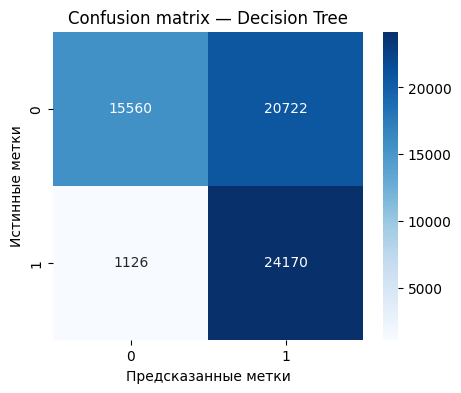

In [31]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Confusion matrix — Decision Tree')
plt.show()


- Много ложноположительных результатов
- Модель почти всех заносит в класс DropOut, даже если студент Graduated

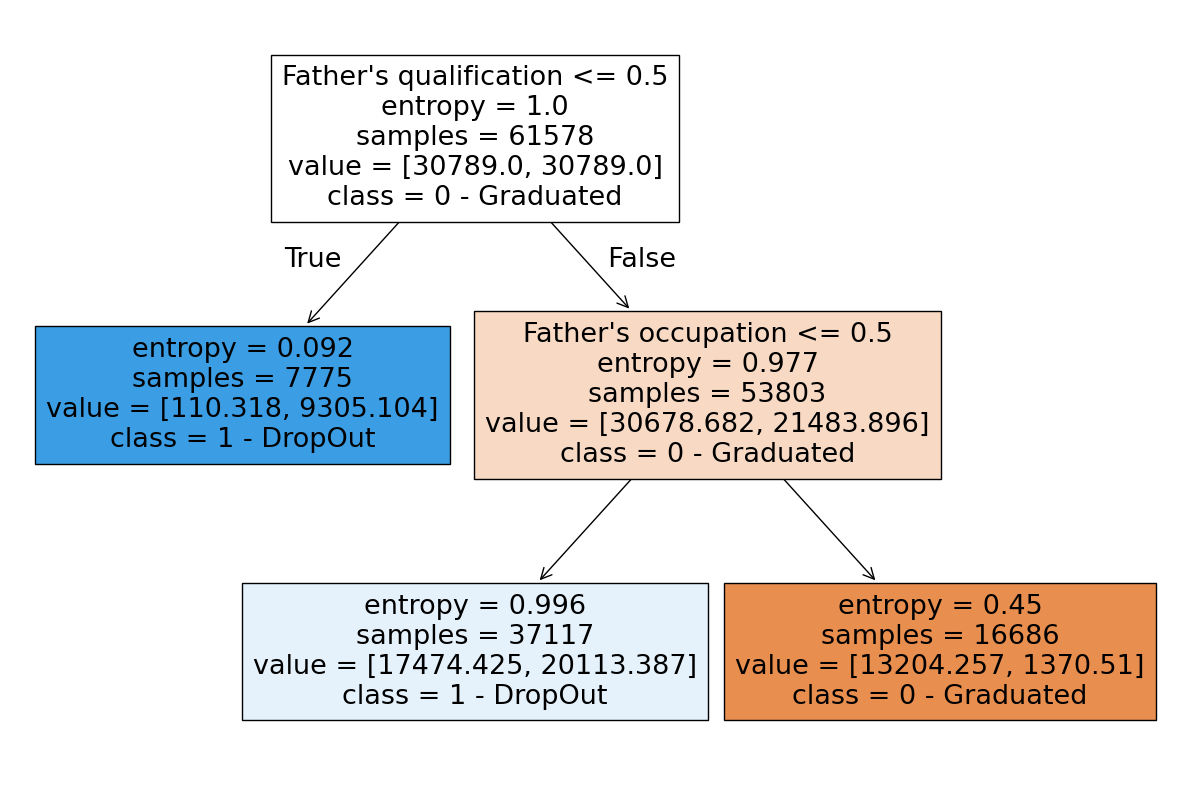

In [33]:
from sklearn import tree

plt.figure(figsize=(15, 10))
tree.plot_tree(
    final_pipeline.named_steps['classifier'], 
    feature_names=X.columns, 
    class_names=["0 - Graduated", "1 - DropOut"], 
    filled=True, 
)
plt.show()

### Вывод:
Модель логистической регрессии справляется лучше 